# Building a Translation System



<a id='1'></a>
## 1 - Understanding the Encoder-Decoder Architecture

The encoder-decoder architecture is a powerful framework for sequence-to-sequence learning tasks. It consists of two main components working in tandem:

1. **The Encoder**: Processes the entire input sequence and creates a rich representation (context) of it
2. **The Decoder**: Takes this context and generates the output sequence step by step

Think of it as a two-stage translation process:
- First, the encoder "understands" the source sentence completely
- Then, the decoder "expresses" this understanding in the target language

<a id='1-1'></a>
### 1.1 How Encoder-Decoder Models Work

The encoder-decoder architecture follows these key principles:

1. **Encoding Phase**: The encoder processes the entire input sequence (e.g., an English sentence) and produces a sequence of hidden states that capture the meaning and context of each word in relation to the entire sentence.

2. **Context Passing**: The encoder's output (hidden states) is passed to the decoder as context. In transformer models, this happens through cross-attention mechanisms.

3. **Decoding Phase**: The decoder generates the output sequence one token at a time, using:
   - The encoder's context (through cross-attention)
   - Previously generated tokens (through self-attention)
   - Learned patterns from training data

4. **Autoregressive Generation**: During inference, the decoder generates tokens sequentially, where each new token depends on all previously generated tokens.

<a id='1-2'></a>
### 1.2 Key Components and Information Flow

The information flow in an encoder-decoder transformer can be visualized as:

```
Input Sequence → Encoder → Context Vectors → Decoder → Output Sequence
     (English)              (Hidden States)              (Desired language)
```

Each component plays a crucial role:
- **Encoder Self-Attention**: Helps each word understand its context within the source sentence
- **Decoder Self-Attention**: Ensures coherence in the generated target sequence
- **Cross-Attention**: Connects source and target, allowing the decoder to "look at" relevant parts of the input when generating each output word

<a id='2'></a>
## 2 - Understanding the Encoder-Decoder Architecture

The encoder-decoder architecture transforms input sequences into output sequences through two key components:

1. **Encoder**: Processes the entire input sequence and creates rich contextual representations
2. **Decoder**: Uses the encoder's context to generate the output sequence step-by-step

![Encoder-Decoder Architecture](images/encoder_decoder_architecture.svg)

### Key Information Flow

The architecture follows this pattern:
- **Encoder Self-Attention**: Each input word understands its context within the source sentence
- **Cross-Attention**: Decoder "looks at" relevant input parts when generating each output word  
- **Decoder Self-Attention**: Ensures coherence in the generated sequence
- **Autoregressive Generation**: Each new output token depends on previously generated tokens

This design enables effective sequence-to-sequence learning for tasks like machine translation.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import math

import numpy as np

# For data handling
from collections import Counter

In [2]:
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [3]:
import helper_utils
import unittests

<a id='2-1'></a>
### 2.1 Loading the Translation Dataset


In [4]:
translation_pairs, target_language = helper_utils.load_dataset()

Available translation pairs (to/from English):
1. English ↔ French
2. English ↔ Spanish
3. English ↔ German
4. English ↔ Italian
5. English ↔ Portuguese
6. English ↔ Russian



Select a language (enter number):  3



You selected: English ↔ German
Extracting German dataset...
Extraction complete!
Loaded 320340 English-German translation pairs

Random sample English-German pairs:
English: Tom spent hours trying to figure out what was going on.
German: Tom rätselte stundenlang herum, was los war.
--------------------------------------------------
English: Could you help us translate this text?
German: Könntest du uns helfen, diesen Text zu übersetzen?
--------------------------------------------------
English: I wonder why Tom is naked.
German: Ich frage mich, warum Tom nackt ist.
--------------------------------------------------
English: Do you know what Tom and I are supposed to be doing now?
German: Weißt du, was Tom und ich jetzt tun sollen?
--------------------------------------------------
English: I won't be able to pick up Tom at the airport.
German: Ich kann Tom nicht vom Flughafen abholen.
--------------------------------------------------


<a id='2-2'></a>
### 2.2 Data Preprocessing and Tokenization



In [5]:
normalized_pairs, tokenizer = helper_utils.prepare_data(
    translation_pairs, 
    target_language,
    max_pairs=150000,  # Process first 150,000 pairs for faster training
    max_length=40      # Keep sentences with <= 40 words
)

# Cell 4: Check some normalized pairs
import random

print(f"\nRandom normalized {target_language} pairs:")
random_samples = random.sample(normalized_pairs, min(3, len(normalized_pairs)))
for eng, target in random_samples:
    print(f"EN: {eng}")
    print(f"{target_language}: {target}")
    print("-" * 40)

# Cell 5: Use the tokenizer on custom text
custom_text = "I love programming!"
tokens = tokenizer(custom_text)
print(f"\nCustom text: {custom_text}")
print(f"Tokens: {tokens}")


=== Tokenizer Test for German ===
Original: Hello, how are you?
Tokenized: ['hello', 'how', 'are', 'you', '?']

Original: He's going to the store.
Tokenized: ["he's", 'going', 'to', 'the', 'store', '.']

Original: I can't believe it's working!
Tokenized: ['i', "can't", 'believe', "it's", 'working', '!']

Original: They're here, aren't they?
Tokenized: ["they're", 'here', "aren't", 'they', '?']


German sample: geh .
German tokenized: ['geh', '.']

=== Data Preparation Complete ===
Normalized pairs: 150000 (from 150000 original pairs)

Random normalized German pairs:
EN: i'm outside .
German: ich bin draußen .
----------------------------------------
EN: nobody wants you to do that .
German: keiner will dass du das tust .
----------------------------------------
EN: tom didn't last long .
German: tom hat nicht lange durchgehalten .
----------------------------------------

Custom text: I love programming!
Tokens: ['i', 'love', 'programming', '!']


<a id='3'></a>
## 3 - Building Vocabulary and Creating Data Loaders

<a id='3-1'></a>
### 3.1 Building Vocabularies



In [6]:
def build_vocab(sentences, tokenizer, min_freq=1):
    """
    Build vocabulary from sentences
    """
    counter = Counter()  # Counter to count word frequencies in all sentences
    for sent in sentences:
        counter.update(tokenizer(sent))  # Tokenize sentence and add token counts
    
    # Start vocab with special tokens for translation
    # <pad>: padding token, <unk>: unknown token, <sos>: start of sequence, <eos>: end of sequence
    vocab = ['<pad>', '<unk>', '<sos>', '<eos>'] + [w for w, c in counter.items() if c >= min_freq]
    
    # Create a mapping from word to unique index
    word2idx = {w: i for i, w in enumerate(vocab)}
    # Create a mapping from index back to word (inverse of word2idx)
    idx2word = {i: w for i, w in enumerate(vocab)}
    
    # Return the vocab list and the two dictionaries
    return vocab, word2idx, idx2word

In [7]:
# Extract English and target language sentences separately
eng_sentences = [eng for eng, tgt in normalized_pairs]
tgt_sentences = [tgt for eng, tgt in normalized_pairs]

# Build vocabularies for both languages
print("Building English vocabulary...")
eng_vocab, eng_word2idx, eng_idx2word = build_vocab(eng_sentences, tokenizer, min_freq=2)
print(f"English vocab size: {len(eng_vocab)}")
print(f"First 20 English vocab words: {eng_vocab[:20]}")

print(f"\nBuilding {target_language} vocabulary...")
tgt_vocab, tgt_word2idx, tgt_idx2word = build_vocab(tgt_sentences, tokenizer, min_freq=2)
print(f"{target_language} vocab size: {len(tgt_vocab)}")
print(f"First 20 {target_language} vocab words: {tgt_vocab[:20]}")

Building English vocabulary...
English vocab size: 7727
First 20 English vocab words: ['<pad>', '<unk>', '<sos>', '<eos>', 'go', '.', 'hi', 'run', '!', 'wow', 'duck', 'fire', 'help', 'hide', 'stay', 'stop', 'wait', 'begin', 'do', 'it']

Building German vocabulary...
German vocab size: 11976
First 20 German vocab words: ['<pad>', '<unk>', '<sos>', '<eos>', 'geh', '.', 'hallo', '!', 'grüß', 'gott', 'lauf', 'potzdonner', 'donnerwetter', 'kopf', 'runter', 'feuer', 'hilfe', 'zu', 'versteck', 'dich']


<a id='3-2'></a>
### 3.2 Preparing Translation Pairs



In [8]:
def prepare_sequence(sentence, tokenizer, word2idx, max_length=20, add_special_tokens=True):
    """
    Convert a sentence to a list of indices with special tokens
    """
    tokens = tokenizer(sentence)
    
    if add_special_tokens:
        # Add <sos> at the beginning and <eos> at the end
        tokens = ['<sos>'] + tokens + ['<eos>']
    
    # Convert tokens to indices
    indices = [word2idx.get(token, word2idx['<unk>']) for token in tokens]
    
    # Pad or truncate to max_length
    if len(indices) < max_length:
        # Pad with <pad> tokens
        indices = indices + [word2idx['<pad>']] * (max_length - len(indices))
    else:
        # Truncate if too long
        indices = indices[:max_length]
    
    return indices

In [9]:
# Prepare all translation pairs
MAX_LENGTH = 40
prepared_pairs = []

for eng, tgt in normalized_pairs:
    # Prepare source (English) - no special tokens for encoder input
    eng_tokens = tokenizer(eng)
    eng_indices = [eng_word2idx.get(token, eng_word2idx['<unk>']) for token in eng_tokens]
    
    # Pad or truncate
    if len(eng_indices) < MAX_LENGTH:
        eng_indices = eng_indices + [eng_word2idx['<pad>']] * (MAX_LENGTH - len(eng_indices))
    else:
        eng_indices = eng_indices[:MAX_LENGTH]
    
    # Prepare target - with special tokens for decoder
    tgt_indices = prepare_sequence(tgt, tokenizer, tgt_word2idx, MAX_LENGTH, add_special_tokens=True)
    
    prepared_pairs.append((eng_indices, tgt_indices))

print(f"Number of prepared pairs: {len(prepared_pairs)}")

# Show an example pair
example_idx = 0
eng_indices, tgt_indices = prepared_pairs[example_idx]

print("\nExample prepared pair:")
print(f"Original English: {normalized_pairs[example_idx][0]}")
print(f"English tokens: {[eng_idx2word[i] for i in eng_indices if i != eng_word2idx['<pad>']]}")
print(f"English indices: {eng_indices}")

print(f"\nOriginal {target_language}: {normalized_pairs[example_idx][1]}")
print(f"{target_language} tokens: {[tgt_idx2word[i] for i in tgt_indices if i != tgt_word2idx['<pad>']]}")
print(f"{target_language} indices: {tgt_indices}")

Number of prepared pairs: 150000

Example prepared pair:
Original English: go .
English tokens: ['go', '.']
English indices: [4, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Original German: geh .
German tokens: ['<sos>', 'geh', '.', '<eos>']
German indices: [2, 4, 5, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


<a id='3-3'></a>
### 3.3 Creating PyTorch Dataset and DataLoaders



In [10]:
from torch.utils.data import Dataset

class TranslationDataset(Dataset):
    """
    PyTorch Dataset for translation pairs
    """
    def __init__(self, pairs):
        self.pairs = pairs
    
    def __len__(self):
        return len(self.pairs)
    
    def __getitem__(self, idx):
        src_indices, tgt_indices = self.pairs[idx]
        
        # Convert to tensors
        src_tensor = torch.tensor(src_indices, dtype=torch.long)
        tgt_tensor = torch.tensor(tgt_indices, dtype=torch.long)
        
        return src_tensor, tgt_tensor

In [11]:
import torch
from torch.utils.data import DataLoader, Subset

# Create the full dataset
full_dataset = TranslationDataset(prepared_pairs)

# Create random indices for splitting
total_size = len(full_dataset)
indices = list(range(total_size))

# Shuffle indices with seed for reproducibility
torch.manual_seed(42)
indices = torch.randperm(total_size).tolist()

# Calculate split point
split_point = int(0.9 * total_size)

# Create train and validation indices
train_indices = indices[:split_point]
val_indices = indices[split_point:]

# Create subset datasets
train_dataset = Subset(full_dataset, train_indices)
val_dataset = Subset(full_dataset, val_indices)

print(f"Training pairs: {len(train_dataset)}")
print(f"Validation pairs: {len(val_dataset)}")

# Create data loaders
BATCH_SIZE = 64
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Test the data loader
for src_batch, tgt_batch in train_loader:
    print(f"Source batch shape: {src_batch.shape}")
    print(f"Target batch shape: {tgt_batch.shape}")
    # Show first example from batch
    print(f"\nFirst example in batch:")
    src_tokens = [eng_idx2word[idx.item()] for idx in src_batch[0] if idx.item() != eng_word2idx['<pad>']]
    tgt_tokens = [tgt_idx2word[idx.item()] for idx in tgt_batch[0] if idx.item() != tgt_word2idx['<pad>']]
    print(f"Source (English): {' '.join(src_tokens)}")
    print(f"Target ({target_language}): {' '.join(tgt_tokens)}")
    break

Training pairs: 135000
Validation pairs: 15000
Source batch shape: torch.Size([64, 40])
Target batch shape: torch.Size([64, 40])

First example in batch:
Source (English): tom is deceitful .
Target (German): <sos> tom ist <unk> . <eos>


<a id='4'></a>
## 4 - Building the Encoder-Decoder Architecture

<a id='4-1'></a>
### 4.1 Helper Functions for Masking



#### Understanding Padding Masks

When  batch sequences together, they often have different lengths. padding shorter sequences with zeros to make all sequences the same length:

```
Original sentences:
"I am" → ['I', 'am'] → [34, 67]
"She loves cats" → ['She', 'loves', 'cats'] → [12, 89, 45]

After padding (assuming max_length=5):
[34, 67, 0, 0, 0]  # "I am" + padding
[12, 89, 45, 0, 0]  # "She loves cats" + padding
```

The padding mask tells the model to ignore these padding positions:

In [12]:
def create_padding_mask(seq, pad_idx=0):
    """
    Create a mask to hide padding tokens
    Args:
        seq: Input sequence tensor [batch_size, seq_length]
        pad_idx: Index used for padding (usually 0)
    Returns:
        Boolean mask where True = ignore this position
    """
    return (seq == pad_idx)

In [13]:
padded_seq = create_padding_mask(np.array([34, 67, 0, 0, 0]))
print(padded_seq)

[False False  True  True  True]


**Example:**
```
Input sequence: [34, 67, 0, 0, 0]
Padding mask:   [False, False, True, True, True]
                   ↑      ↑      ↑     ↑     ↑
                 Keep   Keep  Ignore Ignore Ignore
```

#### Understanding Causal Masks (Look-Ahead Masks)

During training, the decoder generates tokens one at a time. To prevent it from "cheating" by looking at future tokens it hasn't generated yet, use a causal mask:

In [14]:
def make_causal_mask(size):
    """
    Create a mask to hide future tokens (for decoder self-attention)
    Args:
        size: Sequence length
    Returns:
        Upper triangular matrix where True = ignore this position
    """
    mask = torch.triu(torch.ones(size, size), diagonal=1).bool()
    return mask

In [15]:
# Example: Decoder input with padding
decoder_input = ['<sos>', 'Hello', 'world', '<pad>', '<pad>']
indices = [2, 34, 67, 0, 0]

# Create both masks
padding_mask = create_padding_mask(indices)  # [F, F, F, T, T]
subsequent_mask = make_causal_mask(5)   # Upper triangular matrix
print(subsequent_mask)

tensor([[False,  True,  True,  True,  True],
        [False, False,  True,  True,  True],
        [False, False, False,  True,  True],
        [False, False, False, False,  True],
        [False, False, False, False, False]])


Combined effect:
- Position 0: Can see position 0 only (not padding)
- Position 1: Can see positions 0-1 (not padding)
- Position 2: Can see positions 0-2 (not padding)
- Positions 3-4: Ignored (they're padding)

<a id='4-2'></a>
### 4.2 Positional Encoding

Transformers, unlike RNNs or LSTMs, process all tokens in a sequence simultaneously through attention mechanisms. This parallel processing is powerful but comes with a limitation: the model has no inherent understanding of word order. Without position information, "The cat chased the dog" would be indistinguishable from "The dog chased the cat" to the model.

Positional encoding solves this by adding position-dependent signals to the word embeddings. These signals use sinusoidal functions with different frequencies - think of it like giving each position in the sequence a unique "signature" that the model can learn to interpret. The clever use of sine and cosine functions at different frequencies allows the model to learn relative positions (how far apart two words are) and absolute positions (where in the sentence a word appears). This positional information is simply added to the word embeddings, allowing the model to distinguish between the same word appearing in different positions.

In [16]:
class PositionalEncoding(nn.Module):
    """
    Adds positional information to token embeddings using sinusoidal patterns.
    
    Since transformers don't have inherent notion of sequence order (unlike RNNs),
    we add positional encodings to give the model information about where each
    token appears in the sequence.
    """
    def __init__(self, max_len, d_model):
        """
        Initialize positional encoding matrix.
        
        Args:
            max_len (int): Maximum sequence length the model will handle
                          (e.g., 100 for sentences up to 100 tokens)
            d_model (int): Dimension of the model's embeddings 
                          (e.g., 256 or 512 - must match embedding size)
        
        Creates a fixed sinusoidal pattern matrix of shape [max_len, d_model]
        where each row represents the positional encoding for that position.
        """
        super().__init__()

        self.max_len = max_len
        self.d_model = d_model
        
        # Create positional encoding matrix
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        
        # Create div_term for the sinusoidal pattern
        div_term = torch.exp(torch.arange(0, d_model, 2).float() *
                           -(torch.log(torch.tensor(10000.0)) / d_model))
        
        # Apply sin to even indices
        pe[:, 0::2] = torch.sin(position * div_term)
        # Apply cos to odd indices  
        pe[:, 1::2] = torch.cos(position * div_term)
        
        # Register as buffer (not trained, but saved with model)
        self.register_buffer('pe', pe.unsqueeze(0))
        
    def forward(self, x):
        """
        Add positional encoding to input embeddings.
        
        Args:
            x (Tensor): Token embeddings of shape [batch_size, seq_len, d_model]
                       where seq_len <= max_len from initialization
        
        Returns:
            Tensor: Positional encodings of shape [batch_size, seq_len, d_model]
                   (same shape as input, ready to be added to embeddings)
        
        Example:
            If x represents embeddings for "I love cats" (3 tokens):
            - Input x shape: [batch_size, 3, 256]
            - Output shape: [batch_size, 3, 256]
            - Returns positions 0, 1, 2 encoded as 256-dim vectors
        """
        seq_len = x.size(1)
        return self.pe[:, :seq_len, :]

<a id='4-3'></a>
### 4.3 Complete Translator Model




### Summary of the Forward Pass Flow:

```
Input indices [batch, seq_len]
    ↓
Token Embedding [batch, seq_len, d_model]
    ↓
+ Positional Encoding [batch, seq_len, d_model]
    ↓
Dropout
    ↓
Transformer Encoder (with padding mask)
    ↓
Memory (contextualized representations) [batch, seq_len, d_model]
```

</details>



In [ ]:
class Encoder(nn.Module):
    """
    Encoder: Processes the source language (English) and creates a context representation
    """
    def __init__(self, vocab_size, d_model=256, nhead=8, num_layers=3, 
                 dim_feedforward=512, max_len=100, dropout=0.1):
        super().__init__()

        
        
        # Token embedding: Converts word indices to vectors
        self.token_emb = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=d_model,
            padding_idx=0
        )
        
        # Positional encoding
        self.pos_enc = PositionalEncoding(
            max_len=max_len,
            d_model=d_model
        )
        
        # Dropout for regularization
        self.dropout = nn.Dropout(dropout) 
         
        # Single encoder layer
        enc_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )

        # Stacked encoder
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer=enc_layer,
            num_layers=num_layers
        )

        
        
    def forward(self, src):
        """
        Args:
            src: Source language token indices [batch_size, seq_len]
        Returns:
            memory: Encoded representation [batch_size, seq_len, d_model]
        """
        
    
        # Create padding mask (True where padding token)
        padding_mask = (src == 0)
        
        # Embed tokens and add positional encoding
        src = self.token_emb(src)
        src = src + self.pos_enc(src)
        
        # Apply dropout
        src = self.dropout(src)
        
        # Pass through transformer encoder
        memory = self.transformer_encoder(
            src,
            src_key_padding_mask=padding_mask
        )

       
        
        return memory, padding_mask

In [19]:
# Usage
encoder = Encoder(
                vocab_size=5000,
                d_model=256,
                nhead=8,
                num_layers=3,
                dim_feedforward=512,
                max_len=100,
                dropout=0.1
)

helper_utils.show_model_layers(encoder)


 Encoder - Main Layers

Layer                          Type                           Parameters
----------------------------------------------------------------------
token_emb                      Embedding                       1,280,000
pos_enc                        PositionalEncoding                      0
dropout                        Dropout                                 0
transformer_encoder            TransformerEncoder              1,581,312
----------------------------------------------------------------------
TOTAL                                                          2,861,312




#### Translation Decoder Architecture

```
Target Tokens → Embedding → Positional Encoding
                ↓
         ┌─────────────────┐
         │  Decoder Block  │
         │                 │
         │ Self-Attention  │ ← Causal mask (no future peeking)
         │       ↓         │
         │ Cross-Attention │ ← Attends to encoder memory  
         │       ↓         │
         │ Feed Forward    │
         └─────────────────┘
                ↓
         Output Projection → Vocabulary Logits
```



### Summary of the Forward Pass Flow:

```
Target indices [batch, seq_len]
    ↓
Token Embedding (scaled) [batch, seq_len, d_model]
    ↓
+ Positional Encoding
    ↓
Dropout
    ↓
Transformer Decoder
  - Self-Attention (with causal mask)
  - Cross-Attention (to encoder memory, no mask!)
  - Feed Forward
    ↓
Layer Normalization
    ↓
Output Projection
    ↓
Logits [batch, seq_len, vocab_size]
```

</details>

#### Expected Behavior:

 decoder should:
- ✅ Accept target sequences AND encoder memory 
- ✅ Generate predictions for the next token at each position  
- ✅ Use cross-attention to "look at" relevant source words
- ✅ Properly mask future tokens during training
- ✅ Output logits over the entire target vocabulary

In [ ]:
class Decoder(nn.Module):
    """
    Decoder component for translation (works with encoder output)
    """
    def __init__(self, vocab_size, d_model=256, nhead=8, num_layers=3,
                 dim_feedforward=512, max_len=100, dropout=0.1):
        super().__init__()

        self.d_model = d_model
        
        
        
        # Token embedding: Converts target word indices to vectors
        self.token_emb = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=d_model,
            padding_idx=0
        )
        
        # Positional encoding for target sequence
        self.pos_enc = PositionalEncoding(
            max_len=max_len,
            d_model=d_model
        )
        
        # Dropout for regularization
        self.dropout = nn.Dropout(dropout) 
        
        # Define the decoder layer with the desired parameters
        dec_layer = nn.TransformerDecoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        
        # Set the transformer decoder by passing the decoder layer and the number of layers
        self.transformer_decoder = nn.TransformerDecoder(
            decoder_layer=dec_layer,
            num_layers=num_layers
        )
        
        # Final layer op: keep it parameter-free to match expected parameter count
        self.ln_final = nn.Identity()

        # Output projection layer: d_model -> vocab_size
        self.output_projection = nn.Linear(d_model, vocab_size)
        
        
        
    def forward(self, tgt, memory, memory_padding_mask=None):
        """
        Args:
            tgt: Target language token indices [batch_size, tgt_seq_len]
            memory: Encoder output [batch_size, src_seq_len, d_model]
            memory_padding_mask: Mask for encoder padding [batch_size, src_seq_len]
        Returns:
            output: Predicted token logits [batch_size, tgt_seq_len, vocab_size]
        """
        
        
        # Create padding mask for target sequence
        tgt_padding_mask = (tgt == 0)
        
        # Create subsequent mask to prevent decoder from looking at future tokens
        tgt_seq_len = tgt.size(1)
        tgt_subsequent_mask = make_causal_mask(tgt_seq_len).to(tgt.device)

        # Convert into token embeddings and scale
        tgt = self.token_emb(tgt) * math.sqrt(self.d_model)
        
        # Add positional encoding so model knows word positions
        tgt = tgt + self.pos_enc(tgt)
        
        # Apply dropout to embedded target
        tgt = self.dropout(tgt)
        
        # Pass through transformer decoder with cross-attention to encoder memory
        decoded = self.transformer_decoder(
            tgt,
            memory,
            tgt_mask=tgt_subsequent_mask,
            memory_mask=None,
            tgt_key_padding_mask=tgt_padding_mask,
            memory_key_padding_mask=memory_padding_mask
        )

        # Final layer op (Identity here)
        decoded = self.ln_final(decoded)

        # Project decoder output to vocabulary size
        output = self.output_projection(decoded)
        
        
        
        return output


In [31]:
decoder = Decoder(vocab_size=5000, d_model=256, nhead=8, num_layers=3)
helper_utils.show_decoder_layers(decoder)


 Decoder - Main Layers

Layer                          Type                           Parameters
----------------------------------------------------------------------
token_emb                      Embedding                       1,280,000
pos_enc                        PositionalEncoding                      0
dropout                        Dropout                                 0
transformer_decoder            TransformerDecoder              2,372,352
ln_final                       Identity                                0
output_projection              Linear                          1,285,000
----------------------------------------------------------------------
TOTAL                                                          4,937,352


In [ ]:
class EncoderDecoder(nn.Module):
    """
    Complete Encoder-Decoder translation model combining encoder and decoder modules
    """
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model=256, nhead=8,
                 num_enc_layers=3, num_dec_layers=3, dim_feedforward=512,
                 max_len=100, dropout=0.1):
        super().__init__()
        
        
        
        # Initialize encoder for source language with source vocabulary size
        self.encoder = Encoder(
            vocab_size=src_vocab_size,
            d_model=d_model,
            nhead=nhead,
            num_layers=num_enc_layers,
            dim_feedforward=dim_feedforward,
            max_len=max_len,
            dropout=dropout
        )
        
        # Initialize translation decoder for target language with target vocabulary size  
        self.decoder = Decoder(
            vocab_size=tgt_vocab_size,
            d_model=d_model,
            nhead=nhead,
            num_layers=num_dec_layers,
            dim_feedforward=dim_feedforward,
            max_len=max_len,
            dropout=dropout
        )
        
        
        
    def forward(self, src, tgt):
        """
        Args:
            src: Source language token indices [batch_size, src_seq_len]
            tgt: Target language token indices [batch_size, tgt_seq_len]
        Returns:
            output: Predicted token logits [batch_size, tgt_seq_len, tgt_vocab_size]
        """
        
        
        # Encode the source sequence to get memory and source padding mask
        memory, src_padding_mask = self.encoder(src)
        
        # Decode using encoder memory to generate target sequence predictions
        output = self.decoder(tgt, memory, src_padding_mask)
        
        
        
        return output


In [37]:

# Create EncoderDecoder model
model = EncoderDecoder(
    src_vocab_size=5000, 
    tgt_vocab_size=5000, 
    d_model=256, 
    nhead=8, 
    num_enc_layers=3,
    num_dec_layers=3
).to("cuda")

# Show the summary
helper_utils.show_encoderdecoder_layers(model)


 EncoderDecoder - Main Components

Component                      Type                           Parameters
----------------------------------------------------------------------
encoder                        Encoder                         2,861,312
decoder                        Decoder                         4,937,352
----------------------------------------------------------------------
TOTAL                                                          7,798,664


<a id='4-4'></a>
### 4.4 Instantiating the Model



In [39]:
# Model hyperparameters (in section 4.4)
D_MODEL = 256
NHEAD = 8
NUM_ENC_LAYERS = 3
NUM_DEC_LAYERS = 3
DIM_FEEDFORWARD = 512
DROPOUT = 0.1

# Create the model with dynamic vocabulary sizes
model = EncoderDecoder(
    src_vocab_size=len(eng_vocab),
    tgt_vocab_size=len(tgt_vocab),  # Uses target language vocab
    d_model=D_MODEL,
    nhead=NHEAD,
    num_enc_layers=NUM_ENC_LAYERS,
    num_dec_layers=NUM_DEC_LAYERS,
    dim_feedforward=DIM_FEEDFORWARD,
    max_len=MAX_LENGTH,
    dropout=DROPOUT
).to(device)

helper_utils.show_encoderdecoder_layers(model)


 EncoderDecoder - Main Components

Component                      Type                           Parameters
----------------------------------------------------------------------
encoder                        Encoder                         3,559,424
decoder                        Decoder                         8,516,040
----------------------------------------------------------------------
TOTAL                                                         12,075,464


<a id='4-5'></a>
### 4.5 Testing the Model Forward Pass

verifying that the model works correctly by passing a sample batch through it.

In [40]:
# Test the model with a sample batch
for src_batch, tgt_batch in train_loader:
    src_batch = src_batch.to(device)
    tgt_batch = tgt_batch.to(device)
    
    # Use all but last token as input to decoder
    tgt_input = tgt_batch[:, :-1]
    
    # Forward pass
    output = model(src_batch, tgt_input)
    
    print(f"Source shape: {src_batch.shape}")
    print(f"Target input shape: {tgt_input.shape}")
    print(f"Output shape: {output.shape}")
    print(f"Output dimension matches target vocabulary: {output.shape[-1] == len(tgt_vocab)}")
    
    break

Source shape: torch.Size([64, 40])
Target input shape: torch.Size([64, 39])
Output shape: torch.Size([64, 39, 11976])
Output dimension matches target vocabulary: True


<a id='5'></a>
## 5 - Training the Translator

<a id='5-1'></a>
### 5.1 Initializing Training Components

 initializing the optimizer and the loss function.

In [41]:
# Initialize optimizer and criterion
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(ignore_index=0)  # Ignore padding tokens

print(f"Training setup:")
print(f"  Optimizer: Adam (lr=0.001)")
print(f"  Loss function: CrossEntropyLoss")
print(f"  Training batches: {len(train_loader)}")
print(f"  Validation batches: {len(val_loader)}")
print("-" * 50)

Training setup:
  Optimizer: Adam (lr=0.001)
  Loss function: CrossEntropyLoss
  Training batches: 2110
  Validation batches: 235
--------------------------------------------------


<a id='5-2'></a>
### 5.2 Train the Model

 training the translator model.

In [42]:
# Train the model (increase number of epochs to get better results but longer training time)
NUM_EPOCHS = 2

print("Starting training...")
history = helper_utils.train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    num_epochs=NUM_EPOCHS
)

print("Training completed!")

Starting training...


Epoch 1/2 [Train]: 100%|██████████| 2110/2110 [00:58<00:00, 36.18it/s, loss=1.926]


Epoch 1: Train Loss: 2.420, Val Loss: 1.612



Epoch 2/2 [Train]: 100%|██████████| 2110/2110 [00:59<00:00, 35.46it/s, loss=1.119]


Epoch 2: Train Loss: 1.467, Val Loss: 1.288

Training completed!


<a id='5-3'></a>
### 5.3 Visualize Training Progress

Plot the training and validation losses to see how the model learned over time.

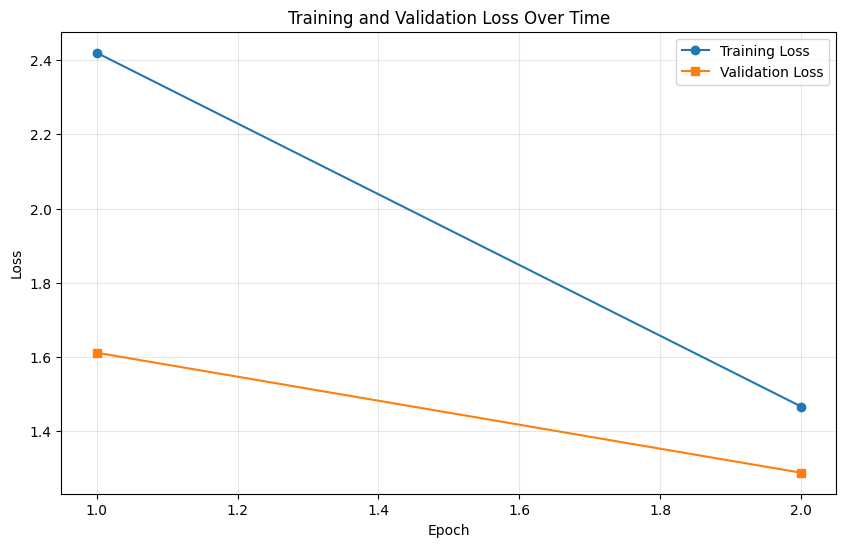

Final Training Loss: 1.4665
Final Validation Loss: 1.2883
Best Validation Loss: 1.2883
Best Validation Loss at Epoch: 2


In [43]:
helper_utils.plot_training_history(history)

## 5.5 Generating Translations with the Trained Model



### How Translation Generation Works



1. **Start with `<sos>`**: Begin the target sequence with the start-of-sequence token
2. **Generate one token at a time**: Feed the current partial translation to the decoder
3. **Select the next word**: Choose the most likely next token from the model's predictions
4. **Repeat**: Add the predicted token to the sequence and continue
5. **Stop at `<eos>`**: End generation when the model predicts the end-of-sequence token

### Greedy Decoding

The implementation below uses **greedy decoding** - at each step, it simply choose the token with the highest probability. While this doesn't always produce the best translation (beam search would be better), it's simple and effective for demonstration purposes.

### The Translation Function

The following function handles the complete translation pipeline:
- Preprocessing the input sentence (tokenization, conversion to indices)
- Managing padding and tensor formatting
- Performing the autoregressive generation
- Converting the output back to readable text

In [44]:
def translate_sentence(model, sentence, src_word2idx, tgt_idx2word, tokenizer, max_length=20, temperature=1.0, debug=False):
    """
    Translate a single sentence using greedy decoding with optional temperature sampling
    """
    model.eval()
    
    # Create reverse mapping for target vocabulary
    tgt_word2idx = {word: idx for idx, word in tgt_idx2word.items()}
    
    # Tokenize and convert to indices
    tokens = tokenizer(sentence.lower())
    src_indices = [src_word2idx.get(token, src_word2idx['<unk>']) for token in tokens]
    
    if debug:
        print(f"Input tokens: {tokens}")
        print(f"Input indices: {src_indices}")
    
    # Pad source to max_length
    if len(src_indices) < max_length:
        src_indices = src_indices + [src_word2idx['<pad>']] * (max_length - len(src_indices))
    else:
        src_indices = src_indices[:max_length]
    
    # Convert to tensor and add batch dimension
    src_tensor = torch.tensor(src_indices).unsqueeze(0).to(device)
    
    # Generate translation using autoregressive decoding
    with torch.no_grad():
        # Get encoder output and source padding mask
        encoder_memory, src_padding_mask = model.encoder(src_tensor)
        
        if debug:
            print(f"Encoder memory shape: {encoder_memory.shape}")
            print(f"Source padding mask shape: {src_padding_mask.shape}")
        
        # Start with <sos> token
        tgt_indices = [tgt_word2idx['<sos>']]
        
        for step in range(max_length - 1):
            # Create target tensor with only tokens generated so far
            tgt_tensor = torch.tensor(tgt_indices).unsqueeze(0).to(device)
            
            # Pass to decoder with encoder memory
            decoder_output = model.decoder(
                tgt_tensor, 
                memory=encoder_memory,
                memory_padding_mask=src_padding_mask
            )
            
            # Get prediction for the NEXT token (from last position)
            next_token_logits = decoder_output[0, -1, :]  # Last position predicts next token
            
            if debug and step < 3:
                print(f"Step {step}: Logits shape: {next_token_logits.shape}")
                print(f"Step {step}: Top 5 logits: {torch.topk(next_token_logits, 5)}")
            
            # Apply temperature for more diverse sampling
            if temperature != 1.0:
                next_token_logits = next_token_logits / temperature
            
            # Use sampling instead of pure greedy for better diversity
            if temperature > 1.0:
                probs = torch.softmax(next_token_logits, dim=-1)
                next_token = torch.multinomial(probs, 1).item()
            else:
                next_token = torch.argmax(next_token_logits).item()
            
            if debug and step < 3:
                print(f"Step {step}: Selected token: {next_token} ({tgt_idx2word.get(next_token, 'UNK')})")
            
            # Add predicted token to sequence
            tgt_indices.append(next_token)
            
            # Stop if <eos> token is generated
            if next_token == tgt_word2idx['<eos>']:
                break
    
    # Convert indices to words (exclude special tokens)
    translated_tokens = [tgt_idx2word[idx] for idx in tgt_indices 
                        if idx not in [tgt_word2idx['<pad>'], tgt_word2idx['<sos>'], tgt_word2idx['<eos>']]]
    
    if debug:
        print(f"Final target indices: {tgt_indices}")
        print(f"Translated tokens: {translated_tokens}")
    
    return ' '.join(translated_tokens)

# Quick debug version
def debug_translate(model, sentence, src_word2idx, tgt_idx2word, tokenizer, max_length=20):
    """Debug version with temperature and verbose output"""
    print(f"\n🔍 DEBUG: Translating '{sentence}'")
    print("=" * 50)
    
    # Try with different temperatures
    print("\n1. Greedy (temperature=1.0):")
    result1 = translate_sentence(model, sentence, src_word2idx, tgt_idx2word, tokenizer, 
                               max_length, temperature=1.0, debug=True)
    print(f"Result: '{result1}'")
    
    print("\n2. With temperature=1.5:")
    result2 = translate_sentence(model, sentence, src_word2idx, tgt_idx2word, tokenizer, 
                               max_length, temperature=1.5, debug=False)
    print(f"Result: '{result2}'")
    
    print("\n3. With temperature=2.0:")
    result3 = translate_sentence(model, sentence, src_word2idx, tgt_idx2word, tokenizer, 
                               max_length, temperature=2.0, debug=False)
    print(f"Result: '{result3}'")
    
    return result1

<a id='5-4'></a>
### 5.4 Test Translation on Training Examples



In [45]:
# Test on some training examples
print("Testing on training examples:")
print("=" * 60)

# Select a few examples from the training set
test_indices = [0, 100, 200, 300, 400]

for idx in test_indices:
    eng_sentence, fra_reference = normalized_pairs[idx]
    
    # Translate
    translation = translate_sentence(model, eng_sentence, eng_word2idx, tgt_idx2word, tokenizer)
    
    print(f"English:    {eng_sentence}")
    print(f"Reference:  {fra_reference}")
    print(f"Translated: {translation}")
    print("-" * 60)

Testing on training examples:
English:    go .
Reference:  geh .
Translated: geh !
------------------------------------------------------------
English:    no way !
Reference:  unmöglich !
Translated: es ist nicht weg !
------------------------------------------------------------
English:    go away .
Reference:  gehen sie weg .
Translated: geh weg !
------------------------------------------------------------
English:    show me .
Reference:  zeig's mir !
Translated: zeig mir !
------------------------------------------------------------
English:    get lost !
Reference:  geh weg !
Translated: steh !
------------------------------------------------------------
